In [11]:
# Deepfake Face Classification with ResNeXt101 and PyTorch

# Block 1: Install & import necessary packages
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
import cv2
import numpy as np
import os
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [12]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
# Block 2: Face-aware frame extraction function
face_cascade = cv2.CascadeClassifier(
    cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
)

def extract_faces_from_video(
    video_path,
    frame_count=10,
    output_size=(128,128),
    face_cascade=face_cascade
):
    cap = cv2.VideoCapture(video_path)
    total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    step = max(total // frame_count, 1)

    faces = []
    for i in range(frame_count):
        cap.set(cv2.CAP_PROP_POS_FRAMES, i * step)
        ret, frame = cap.read()
        if not ret:
            break
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        dets = face_cascade.detectMultiScale(
            gray, scaleFactor=1.1, minNeighbors=5
        )
        if len(dets) > 0:
            x, y, w, h = max(dets, key=lambda r: r[2]*r[3])
            face = frame[y:y+h, x:x+w]
            face = cv2.resize(face, output_size)
            faces.append(face)
    cap.release()
    return faces  # list of 10 cropped face images or fewer


In [14]:
# Block 3: Prepare face dataset (extract, label, split)
REAL_VID_DIR = "/kaggle/input/faceforensics/FF++/real"
FAKE_VID_DIR = "/kaggle/input/faceforensics/FF++/fake"
FRAME_COUNT = 10
TMP_DIR = "./faces_tmp"
os.makedirs(TMP_DIR, exist_ok=True)

filepaths, labels = [], []

# extract faces and save images
for label, vid_dir in [(0, REAL_VID_DIR), (1, FAKE_VID_DIR)]:
    for vf in tqdm(os.listdir(vid_dir)[:200], desc=f"Processing {'Real' if label==0 else 'Fake'}"):
        vid_path = os.path.join(vid_dir, vf)
        faces = extract_faces_from_video(vid_path, FRAME_COUNT)
        if len(faces) == FRAME_COUNT:
            for idx, face in enumerate(faces):
                out_path = os.path.join(TMP_DIR, f"{label}_{vf}_{idx}.jpg")
                cv2.imwrite(out_path, face)
                filepaths.append(out_path)
                labels.append(label)

# train/val split
X_train, X_val, y_train, y_val = train_test_split(
    filepaths, labels, test_size=0.2, stratify=labels, random_state=42
)


Processing Fake: 100%|██████████| 200/200 [23:48<00:00,  7.14s/it]


In [16]:
# Block 4: Dataset and DataLoader
class FaceFrameDataset(Dataset):
    def __init__(self, paths, labels, transform=None):
        self.paths = paths
        self.labels = labels
        self.transform = transform
    def __len__(self): return len(self.paths)
    def __getitem__(self, idx):
        img = cv2.imread(self.paths[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if self.transform:
            img = self.transform(img)
        return img, self.labels[idx]

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
])

train_ds = FaceFrameDataset(X_train, y_train, transform)
val_ds   = FaceFrameDataset(X_val,   y_val,   transform)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False)

In [17]:
# Block 5: Load ResNeXt101 classifier
model = models.resnext101_32x8d(pretrained=True)
for param in model.parameters(): param.requires_grad = False
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, 2)
)
model = model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt101_32X8D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt101_32X8D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [18]:

# Block 6: Training loop
def train(model, train_loader, val_loader, epochs=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.fc.parameters(), lr=1e-4)
    for epoch in range(epochs):
        model.train()
        total_loss, total_correct = 0, 0
        for imgs, lbls in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            imgs, lbls = imgs.to(device), lbls.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, lbls)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * imgs.size(0)
            total_correct += (outputs.argmax(1)==lbls).sum().item()
        print(f"Train Loss: {total_loss/len(train_loader.dataset):.4f}",
              f"Acc: {total_correct/len(train_loader.dataset):.4f}")

        model.eval()
        val_loss, val_correct = 0, 0
        with torch.no_grad():
            for imgs, lbls in val_loader:
                imgs, lbls = imgs.to(device), lbls.to(device)
                out = model(imgs)
                val_loss += criterion(out, lbls).item() * imgs.size(0)
                val_correct += (out.argmax(1)==lbls).sum().item()
        print(f"Val Loss: {val_loss/len(val_loader.dataset):.4f}",
              f"Val Acc: {val_correct/len(val_loader.dataset):.4f}\n")


In [20]:
# Block 7: Run training
train(model, train_loader, val_loader, epochs=40)

Epoch 1: 100%|██████████| 76/76 [00:07<00:00,  9.73it/s]


Train Loss: 0.3081 Acc: 0.8697
Val Loss: 0.3699 Val Acc: 0.8273



Epoch 2: 100%|██████████| 76/76 [00:07<00:00,  9.72it/s]


Train Loss: 0.3174 Acc: 0.8544
Val Loss: 0.3466 Val Acc: 0.8602



Epoch 3: 100%|██████████| 76/76 [00:07<00:00,  9.63it/s]


Train Loss: 0.2995 Acc: 0.8680
Val Loss: 0.3542 Val Acc: 0.8487



Epoch 4: 100%|██████████| 76/76 [00:07<00:00,  9.67it/s]


Train Loss: 0.3050 Acc: 0.8643
Val Loss: 0.3740 Val Acc: 0.8289



Epoch 5: 100%|██████████| 76/76 [00:07<00:00,  9.71it/s]


Train Loss: 0.2787 Acc: 0.8816
Val Loss: 0.3497 Val Acc: 0.8454



Epoch 6: 100%|██████████| 76/76 [00:07<00:00,  9.68it/s]


Train Loss: 0.2755 Acc: 0.8836
Val Loss: 0.3341 Val Acc: 0.8487



Epoch 7: 100%|██████████| 76/76 [00:07<00:00,  9.67it/s]


Train Loss: 0.2667 Acc: 0.8816
Val Loss: 0.3411 Val Acc: 0.8569



Epoch 8: 100%|██████████| 76/76 [00:07<00:00,  9.66it/s]


Train Loss: 0.2523 Acc: 0.8939
Val Loss: 0.3340 Val Acc: 0.8635



Epoch 9: 100%|██████████| 76/76 [00:07<00:00,  9.69it/s]


Train Loss: 0.2473 Acc: 0.8984
Val Loss: 0.3481 Val Acc: 0.8454



Epoch 10: 100%|██████████| 76/76 [00:07<00:00,  9.78it/s]


Train Loss: 0.2410 Acc: 0.8956
Val Loss: 0.3352 Val Acc: 0.8553



Epoch 11: 100%|██████████| 76/76 [00:07<00:00,  9.79it/s]


Train Loss: 0.2404 Acc: 0.8993
Val Loss: 0.3232 Val Acc: 0.8569



Epoch 12: 100%|██████████| 76/76 [00:07<00:00,  9.81it/s]


Train Loss: 0.2394 Acc: 0.9046
Val Loss: 0.3147 Val Acc: 0.8684



Epoch 13: 100%|██████████| 76/76 [00:07<00:00,  9.82it/s]


Train Loss: 0.2361 Acc: 0.9054
Val Loss: 0.3168 Val Acc: 0.8783



Epoch 14: 100%|██████████| 76/76 [00:07<00:00,  9.74it/s]


Train Loss: 0.2166 Acc: 0.9083
Val Loss: 0.3084 Val Acc: 0.8750



Epoch 15: 100%|██████████| 76/76 [00:07<00:00,  9.79it/s]


Train Loss: 0.2131 Acc: 0.9141
Val Loss: 0.3833 Val Acc: 0.8520



Epoch 16: 100%|██████████| 76/76 [00:07<00:00,  9.77it/s]


Train Loss: 0.1901 Acc: 0.9268
Val Loss: 0.3061 Val Acc: 0.8832



Epoch 17: 100%|██████████| 76/76 [00:07<00:00,  9.74it/s]


Train Loss: 0.1967 Acc: 0.9211
Val Loss: 0.3289 Val Acc: 0.8750



Epoch 18: 100%|██████████| 76/76 [00:07<00:00,  9.81it/s]


Train Loss: 0.1913 Acc: 0.9231
Val Loss: 0.3111 Val Acc: 0.8816



Epoch 19: 100%|██████████| 76/76 [00:07<00:00,  9.79it/s]


Train Loss: 0.1911 Acc: 0.9194
Val Loss: 0.3059 Val Acc: 0.8816



Epoch 20: 100%|██████████| 76/76 [00:07<00:00,  9.74it/s]


Train Loss: 0.1860 Acc: 0.9293
Val Loss: 0.3403 Val Acc: 0.8602



Epoch 21: 100%|██████████| 76/76 [00:07<00:00,  9.81it/s]


Train Loss: 0.1747 Acc: 0.9338
Val Loss: 0.3140 Val Acc: 0.8799



Epoch 22: 100%|██████████| 76/76 [00:07<00:00,  9.77it/s]


Train Loss: 0.1611 Acc: 0.9367
Val Loss: 0.2978 Val Acc: 0.8849



Epoch 23: 100%|██████████| 76/76 [00:07<00:00,  9.73it/s]


Train Loss: 0.1600 Acc: 0.9416
Val Loss: 0.3201 Val Acc: 0.8783



Epoch 24: 100%|██████████| 76/76 [00:07<00:00,  9.78it/s]


Train Loss: 0.1624 Acc: 0.9396
Val Loss: 0.3181 Val Acc: 0.8766



Epoch 25: 100%|██████████| 76/76 [00:07<00:00,  9.82it/s]


Train Loss: 0.1562 Acc: 0.9465
Val Loss: 0.3286 Val Acc: 0.8684



Epoch 26: 100%|██████████| 76/76 [00:07<00:00,  9.80it/s]


Train Loss: 0.1653 Acc: 0.9350
Val Loss: 0.3285 Val Acc: 0.8766



Epoch 27: 100%|██████████| 76/76 [00:07<00:00,  9.76it/s]


Train Loss: 0.1614 Acc: 0.9379
Val Loss: 0.3206 Val Acc: 0.8783



Epoch 28: 100%|██████████| 76/76 [00:07<00:00,  9.77it/s]


Train Loss: 0.1536 Acc: 0.9412
Val Loss: 0.3105 Val Acc: 0.8717



Epoch 29: 100%|██████████| 76/76 [00:07<00:00,  9.77it/s]


Train Loss: 0.1405 Acc: 0.9433
Val Loss: 0.3268 Val Acc: 0.8717



Epoch 30: 100%|██████████| 76/76 [00:07<00:00,  9.73it/s]


Train Loss: 0.1541 Acc: 0.9412
Val Loss: 0.3100 Val Acc: 0.8783



Epoch 31: 100%|██████████| 76/76 [00:07<00:00,  9.66it/s]


Train Loss: 0.1335 Acc: 0.9527
Val Loss: 0.3014 Val Acc: 0.8849



Epoch 32: 100%|██████████| 76/76 [00:07<00:00,  9.68it/s]


Train Loss: 0.1321 Acc: 0.9482
Val Loss: 0.2967 Val Acc: 0.9013



Epoch 33: 100%|██████████| 76/76 [00:07<00:00,  9.67it/s]


Train Loss: 0.1335 Acc: 0.9486
Val Loss: 0.3029 Val Acc: 0.8783



Epoch 34: 100%|██████████| 76/76 [00:07<00:00,  9.67it/s]


Train Loss: 0.1370 Acc: 0.9494
Val Loss: 0.3053 Val Acc: 0.8898



Epoch 35: 100%|██████████| 76/76 [00:07<00:00,  9.66it/s]


Train Loss: 0.1238 Acc: 0.9552
Val Loss: 0.3090 Val Acc: 0.8898



Epoch 36: 100%|██████████| 76/76 [00:07<00:00,  9.66it/s]


Train Loss: 0.1379 Acc: 0.9445
Val Loss: 0.3059 Val Acc: 0.8849



Epoch 37: 100%|██████████| 76/76 [00:07<00:00,  9.70it/s]


Train Loss: 0.1249 Acc: 0.9531
Val Loss: 0.3293 Val Acc: 0.8832



Epoch 38: 100%|██████████| 76/76 [00:07<00:00,  9.70it/s]


Train Loss: 0.1186 Acc: 0.9552
Val Loss: 0.3143 Val Acc: 0.8799



Epoch 39: 100%|██████████| 76/76 [00:07<00:00,  9.79it/s]


Train Loss: 0.1174 Acc: 0.9544
Val Loss: 0.3058 Val Acc: 0.8832



Epoch 40: 100%|██████████| 76/76 [00:07<00:00,  9.77it/s]


Train Loss: 0.1287 Acc: 0.9461
Val Loss: 0.3089 Val Acc: 0.8816



In [21]:
# Block 8: Save model
torch.save(model.state_dict(), "resnext101_deepfake_faces.pth")

/tmp/ipykernel_31/1050624176.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("resnext101_deepfake_faces.pth", map_location=device))


Test Accuracy: 88.16%

Classification Report:
              precision    recall  f1-score   support

        REAL       0.85      0.91      0.88       282
        FAKE       0.92      0.86      0.89       326

    accuracy                           0.88       608
   macro avg       0.88      0.88      0.88       608
weighted avg       0.88      0.88      0.88       608



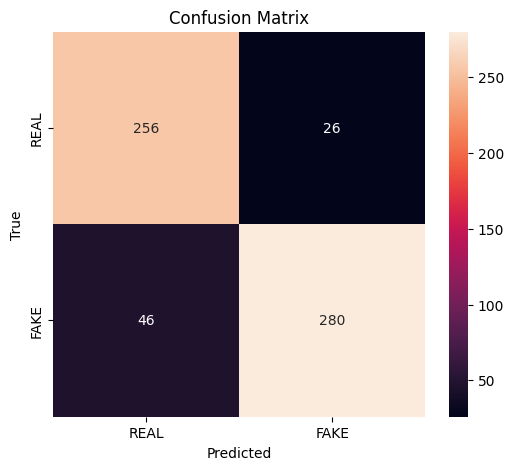

In [22]:
# === Block: Model Testing & Evaluation ===

import torch
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Rebuild dataset & loader for “test” splits:
#    If you already have X_test & y_test lists from your split, skip this and just wrap them,
#    otherwise you can reuse the FaceFrameDataset class and point it at your saved faces.
test_ds = FaceFrameDataset(X_val, y_val, transform)   # or use X_test,y_test if you set aside a test split
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

# 2) Load the trained weights
model.load_state_dict(torch.load("resnext101_deepfake_faces.pth", map_location=device))
model.eval()

# 3) Collect predictions and true labels
all_preds, all_labels = [], []
with torch.no_grad():
    for imgs, lbls in test_loader:
        imgs = imgs.to(device)
        out = model(imgs)
        preds = out.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(lbls.numpy())

all_preds  = np.array(all_preds)
all_labels = np.array(all_labels)

# 4) Compute metrics
acc = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {acc*100:.2f}%\n")

print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=["REAL","FAKE"]))

# 5) Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", 
            xticklabels=["REAL","FAKE"], 
            yticklabels=["REAL","FAKE"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [24]:
import torch

# 1) Ensure your model and utilities are loaded:
#    - model: your ResNeXt101 face‐crop classifier (already .to(device))
#    - extract_faces_from_video(), transform, device from earlier code

# Load trained weights
model.load_state_dict(torch.load("resnext101_deepfake_faces.pth", map_location=device))

# 2) Define the sample video path (replace with your file)
sample_path = "/kaggle/input/faceforensics/FF++/fake/01_02__outside_talking_still_laughing__YVGY8LOK.mp4"

# 3) Run prediction
label, confidence, details = predict_video(
    sample_path,
    model,
    transform,
    device,
    frame_count=10,
    return_details=True
)

# 4) Print results
print("=== Video Deepfake Prediction ===")
print(f"Video File : {sample_path}")
print(f"Prediction : {label}")
print(f"Confidence : {confidence:.2f}")
print("\nPer-frame probabilities:")
for idx, (r_prob, f_prob) in enumerate(zip(details["real_probs"], details["fake_probs"])):
    print(f" Frame {idx+1:2d} → REAL: {r_prob:.2f}, FAKE: {f_prob:.2f}")


/tmp/ipykernel_31/2820769953.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("resnext101_deepfake_faces.pth", map_location=device))


=== Video Deepfake Prediction ===
Video File : /kaggle/input/faceforensics/FF++/fake/01_02__outside_talking_still_laughing__YVGY8LOK.mp4
Prediction : FAKE
Confidence : 0.98

Per-frame probabilities:
 Frame  1 → REAL: 0.00, FAKE: 1.00
 Frame  2 → REAL: 0.00, FAKE: 1.00
 Frame  3 → REAL: 0.04, FAKE: 0.96
 Frame  4 → REAL: 0.00, FAKE: 1.00
 Frame  5 → REAL: 0.01, FAKE: 0.99
 Frame  6 → REAL: 0.12, FAKE: 0.88
 Frame  7 → REAL: 0.00, FAKE: 1.00
 Frame  8 → REAL: 0.01, FAKE: 0.99
 Frame  9 → REAL: 0.01, FAKE: 0.99
 Frame 10 → REAL: 0.00, FAKE: 1.00


In [25]:
import torch

# 1) Ensure your model and utilities are loaded:
#    - model: your ResNeXt101 face‐crop classifier (already .to(device))
#    - extract_faces_from_video(), transform, device from earlier code

# Load trained weights
model.load_state_dict(torch.load("resnext101_deepfake_faces.pth", map_location=device))

# 2) Define the sample video path (replace with your file)
sample_path = "/kaggle/input/faceforensics/FF++/real/01__podium_speech_happy.mp4"

# 3) Run prediction
label, confidence, details = predict_video(
    sample_path,
    model,
    transform,
    device,
    frame_count=10,
    return_details=True
)

# 4) Print results
print("=== Video Deepfake Prediction ===")
print(f"Video File : {sample_path}")
print(f"Prediction : {label}")
print(f"Confidence : {confidence:.2f}")
print("\nPer-frame probabilities:")
for idx, (r_prob, f_prob) in enumerate(zip(details["real_probs"], details["fake_probs"])):
    print(f" Frame {idx+1:2d} → REAL: {r_prob:.2f}, FAKE: {f_prob:.2f}")


/tmp/ipykernel_31/743551065.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("resnext101_deepfake_faces.pth", map_location=device))


=== Video Deepfake Prediction ===
Video File : /kaggle/input/faceforensics/FF++/real/01__podium_speech_happy.mp4
Prediction : REAL
Confidence : 0.97

Per-frame probabilities:
 Frame  1 → REAL: 1.00, FAKE: 0.00
 Frame  2 → REAL: 0.80, FAKE: 0.20
 Frame  3 → REAL: 1.00, FAKE: 0.00
 Frame  4 → REAL: 0.97, FAKE: 0.03
 Frame  5 → REAL: 0.98, FAKE: 0.02
 Frame  6 → REAL: 0.99, FAKE: 0.01
 Frame  7 → REAL: 0.99, FAKE: 0.01
 Frame  8 → REAL: 1.00, FAKE: 0.00
 Frame  9 → REAL: 0.99, FAKE: 0.01
 Frame 10 → REAL: 1.00, FAKE: 0.00
